In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from google.colab import files
import warnings
warnings.filterwarnings(action = 'once')

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (10,6)

In [2]:
from google.colab import drive
drive.mount('content/', force_remount=True)

Mounted at content/


In [4]:
energy_data_path = '/content/content/MyDrive/Project 2020-21/Car data/Paper Data/Four_homes.csv'
price_data_path = '/content/content/MyDrive/Project 2020-21/Car data/Paper Data/price_data.xlsx'

# pow_df = pd.read_excel('Four_homes.xlsx')
pow_df = pd.read_csv(energy_data_path)
price_df = pd.read_excel(price_data_path, sheet_name='cost in rupess')

In [5]:
pow_df.head()

,H1,H2,H3,H4
0,1.137333,2.455300,0.159450,3.848300
1,1.109450,3.859267,0.163283,3.776800
2,0.925433,2.700883,0.181067,1.688600
3,0.859517,4.542017,0.154733,1.094767
4,0.870317,12.954770,0.182217,0.779333


In [6]:
price_df.head()

,Time of the Day,Grid Purchase Cost,Grid Selling Cost,P2P Cost,Grid Purchase Cost.1,Grid Selling Cost.1,P2P Cost.1,Unnamed: 7
0,0,6,4,5,0.13409,0.080454,0.107272,ToU Tariff:
1,1,6,4,5,0.13409,0.080454,0.107272,(Cost of purchase from grid by apartment build...
2,2,6,4,5,0.13409,0.080454,0.107272,"6am-10am, 8 Rs"
3,3,6,4,5,0.13409,0.080454,0.107272,"10am - 6pm, 7 Rs"
4,4,6,4,5,0.13409,0.080454,0.107272,"6pm - 10pm, 8 Rs"


In [7]:
file_path = '/content/content/My Drive/Project 2020-21/Car data/car_data.csv'
vehicle_df = pd.read_csv(file_path)
temp = vehicle_df.temp + 273
vehicle_df.head()

,arr_time,dep_time,soc_initial,soc_final,temp,temp_max,temp_min,Distance travelled,Distance need to travel
0,10,17,0.689,0.481,20.225,29.93,10.52,14,20
1,9,16,0.705,0.426,21.730,31.00,12.46,20,17
2,11,15,0.754,0.386,21.725,30.92,12.53,18,15
3,12,17,0.736,0.464,21.565,31.05,12.08,19,16
4,11,17,0.689,0.442,21.885,31.29,12.48,18,19


### Important functions

In [132]:
def cycle_deg( T, b_current, c_rate, del_t):
    cycle_const = [8.6772e-6, -5.1613e-3, 7.6788e-1, -6.7e-3, 2.35] #[a, b, c, d, e]
    a,b,c,d,e = cycle_const[0], cycle_const[1], cycle_const[2], cycle_const[3], cycle_const[4]
    cells_per_mod = 72

    B1 = a*pow(T,2) + b*T + c
    B2 = d*T + e
    cell_current = b_current / cells_per_mod
    cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    return cycle_loss

def cal_deg2(temp, t):
    alpha, beta = 165000, -4148
    cal_deg = alpha * np.exp(beta/temp) * pow(t,0.5)
    return cal_deg # in %

def hour2min2hour(hour1, hour2):
    """
    hour1 = arrival time,
    hour2 = departure time
    """
    frac_hour1 = hour1 - int(hour1)
    frac_hour2 = hour2 - int(hour2)
    min = ( (int(hour2) - int(hour1))*60 + (frac_hour2 - frac_hour1)*100 ) / 60
    return min

def hour2steps(hour,step_size):
    """
    -> Convert hour into minute.Unit of step_size in minutes
    -> Divide minutes with step size and u will get steps.
    """
    steps = int(hour * 60 / step_size)
    return steps

def myTemp(ambient_temp, power):
    rth = 2 # Celcius / kW
    return ambient_temp + rth * power

def myplot(xvals,yvals, kind='plot', labels=None,xlab=None,ylab=None,titles=None,colors='b',image_name = 'imag.png',save=False, Xticks=None):
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    if kind.lower() == 'bar': 
        plt.bar(xvals,yvals,label = labels, linewidth = 2, color = colors)
    else:
        plt.plot(xvals,yvals,label = labels, linewidth = 2, color = colors)
    plt.xticks(np.arange(0,len(xvals)), Xticks)
    plt.xlabel(xlab,fontsize = 16)
    plt.ylabel(ylab,fontsize = 16)
    plt.title(titles,fontsize = 18,color = 'black',fontweight = 'bold')
    name = image_name
    if save:
        plt.legend()
        plt.grid()
        plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
        files.download(name) 
    plt.legend()
    plt.grid()
    plt.show()

def printf(p):
    def varname(p):
        for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
            m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
            if m:
             return m.group(1)
    print(varname(p) + ": " + str(p))

def changeTimStamp(arr, old_del_t, new_del_t):
    if new_del_t > old_del_t:
        print("New timestamp should be less than old timestamp!")
    elif new_del_t%old_del_t != 0:
        print("New timestamp should be multiple of old timestamp!")
    else:
        repeat = old_del_t // new_del_t
        new_arr = np.repeat(arr, repeat, axis = 0)
    return new_arr

maximum demand of H1: 6.204kW


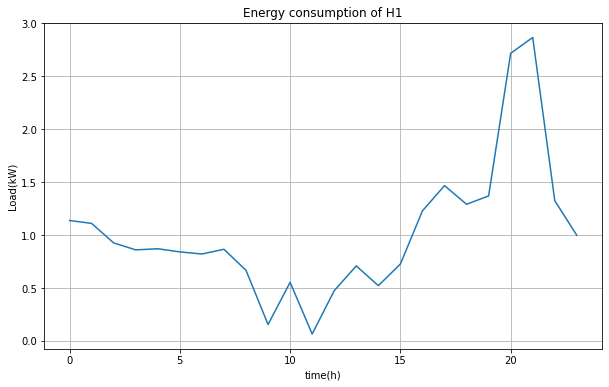

In [13]:
# 1 day profile of H1 data
p1 = pow_df.H1.values[:24]
time = np.arange(len(p1))

plt.plot(time, p1)
plt.xlabel("time(h)")
plt.ylabel("Load(kW)")
plt.title("Energy consumption of H1")
plt.grid()
plt.plot()

print(f"maximum demand of H1: {pow_df.H1.max():.3f}kW")

## Degradation program for 1 day at a step size of 1h

##<font color = 'red'> Assumptions </font>
1. Every day car is charging after 12.00 AM as after that price is minimum.
![picture](https://drive.google.com/uc?export=view&id=1SB4u5rVnVjeMCnpKLmjw4ddbyP6M5msp)

## **Problem**
* There is some problem in SOC vector.
see and rectify it!!...

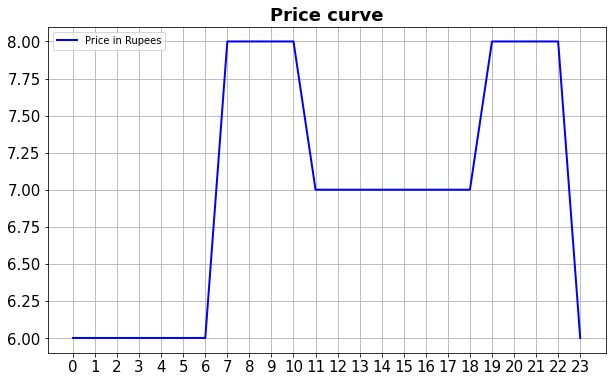

In [133]:
price = [6]*7 + [8]*4 + [7]*8 + [8]*4 + [6]
time = list(range(len(price)))
xlab = "Time(24h format)"
ylab = "Price in Rupees"
title = "Price curve"
xticks = np.arange(0,len(time))
myplot(time, price, xlab, ylab, titles=title, image_name = "price_curve.png", Xticks=xticks, save=not True)

current_step after 365 days is 8760
cum_charge_energy: 5700.604 kWh
cum_disch_energy: 2993.879 kWh
Cal_deg after 365 days is 2.094
Cycle_deg after 365 days is 0.898


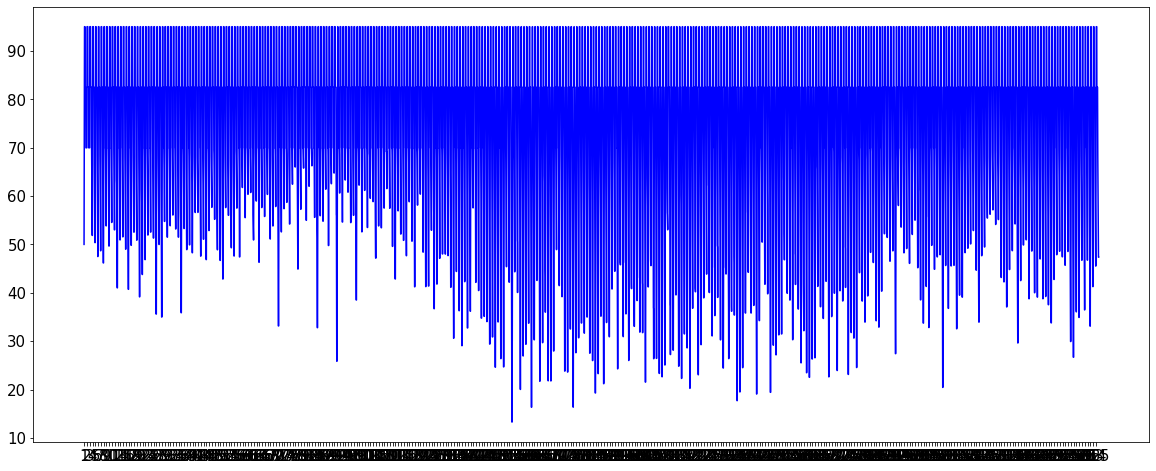

In [134]:
days = 1 * 365
p1 = pow_df.H1.values[:24*days]
new_p1 = p1

del_t = 60 #min
steps = days*24*60//del_t

b_cap = 30.2 # kWh
b_volt = 320
upper_th = 95 # upper SOC threshold
lower_th = 20 # lower SOC threshold
dist_travel = 30 # km(one way)
mileage = 0.126 # kWh/km

build_arr_time = np.random.randint( 10,11, size = days )
build_dep_time = np.random.randint( 16,17, size = days )
home_leave_time = np.random.randint( 9,10, size = days ) # No randomness
home_arr_time = np.random.randint( 17,18, size = days ) # EV arrived 5.00 pm at home

home_charger = 3.3 # kw
rth = 2 # Celcius/kW

price = [6]*7 + [8]*4 + [7]*8 + [8]*4 + [6]

soc = np.zeros(steps+1) 
soc[0] = 50 # initial SOC at 12.00 AM
start_time = 0 # Program start at 12.00 AM

b_percent_cap = np.zeros(len(p1)+1)
b_percent_cap[0] = 100

cum_cal_time = np.zeros(days+1)
cum_cal_deg = np.zeros(days+1)
cum_cycle_deg = np.zeros(days+1)
cum_disch_energy = np.zeros(days+1)
cum_charge_energy = np.zeros(days+1)

current_step = 0
for day in range(days):
    b_cap_kwh = b_percent_cap[day] * b_cap/100    
    daily_cycle_deg, daily_cal_time = 0,0    

    # print("*********")
    # print(f"Day {day+1} starts")
    # print("*********")
    # =================================
    ## 1. Charging at home
    # =================================
    isCharging = True # Initalizing the charging vector
    # Charging the car upto upper threshold(95% in this case).
    if isCharging:
        charged_energy = (0.95 - soc[current_step]/100) * b_cap_kwh # Efficiency can be included here 
        # print("charged_energy:",charged_energy)
        cum_charge_energy[day+1] = cum_charge_energy[day] + charged_energy 
        home_charge_time = charged_energy / home_charger # hour
        charge_steps = hour2steps(home_charge_time, del_t)
        total_soc_increment = upper_th - soc[current_step]
        per_step_increment = total_soc_increment / charge_steps

        for i in range(charge_steps):
            soc[current_step+i+1] = soc[current_step+i] + per_step_increment
        current_step += charge_steps #******
        isCharging = False # Car is already charged to upper threshold
        b_temp = myTemp(temp[day], home_charger)
        if b_temp > 273+45:
            b_temp = 273+45
        b_current = home_charger*1000 / b_volt
        c_rate = home_charger / b_cap_kwh
        for i in range(charge_steps):
            daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
        # print(f"charged_time: {home_charge_time}, charged_steps: {charge_steps}")
        # print(f"current_step after charging at home: {current_step}")
        # print(f"soc increment at home:  {total_soc_increment}")
        # print("====================================")
        # print("\n")
        
        # ============================================
        ## 2.Staying at home for some time(completed)
        # ============================================
        daily_cal_time += home_leave_time[day] - start_time - home_charge_time
        home_cal_steps = hour2steps(daily_cal_time, del_t)
        soc[current_step+1:current_step+1+home_cal_steps] = soc[current_step] # SOC will constant as no self discharge during standing at home.
        current_step += home_cal_steps #******
        # print(f"home_standing_steps: {home_cal_steps}")
        # print(f"current_step after before leaving the home: {current_step}")
        # print("====================================")
        # print("\n")

        # =================================
        ## 3. Going from home to office
        # =================================
        # Degradation is calculated for both but not the SOC.  
        travel_energy = dist_travel * mileage # kWh
        travel_time = 1 # h 
        travel_steps = hour2steps(travel_time,del_t)
        travel_power = travel_energy / travel_time # Const
        total_soc_decrement = travel_energy / b_cap * 100 # fixed soc will decrease as b_cap is fixed
        per_step_decrement = total_soc_decrement / travel_steps
        b_temp = myTemp(temp[day], travel_power)
        if b_temp > 273+45:
            b_temp = 273+45
        b_current = travel_power*1000 / b_volt
        c_rate = travel_power / b_cap_kwh
        for i in range(travel_steps):
            soc[current_step+i+1] = soc[current_step+i] - per_step_decrement
            daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
        daily_cycle_deg *= 2 # from building to home
        current_step += travel_steps #******
        # print(f"SOC: {soc[current_step]}")
        # print(f"travel_steps: {travel_steps}")
        # print(f"current_step after travelling to office: {current_step}")
        # print("====================================")
        # print("\n")
        
        # =================================
        ## 4. At office
        # =================================
        build_stand_time = build_dep_time[day] - build_arr_time[day]
        build_stand_steps = hour2steps(build_stand_time, del_t)
        daily_cal_time += build_stand_time
        soc[current_step+1:current_step+1+build_stand_steps] = soc[current_step] # SOC will constant as no self discharge.
        current_step += build_stand_steps #******
        # print(f"SOC: {soc[current_step]}")
        # print(f"building_stand_time: {build_stand_time}, building_stand_steps: {build_stand_steps}")
        # print(f"current_step after leaving the office: {current_step}")
        # print("====================================")
        # print("\n")

        # =================================
        ## 5. Returning from office to home
        # =================================
        # Degradation is already calculated(see 3)
        for i in range(travel_steps):
            soc[current_step+i+1] = soc[current_step+i] - per_step_decrement
        current_step += travel_steps #******
        # print(f"SOC: {soc[current_step]}")
        # print(f"travel_steps: {travel_steps}")
        # print(f"current_step after reaching at home: {current_step}")
        # print("====================================")
        # print("\n")

        # =================================
        ## 6. Discharging at home
        # =================================
        # Car will be discharged into home to satisfy the evening peak of the load.(4h).
        home_disch_time = 6 # hour
        disch_steps = hour2steps(home_disch_time, del_t)
        
        # print(f"current_step before disch_home: {current_step}")
        # print(f"disch_steps: {disch_steps}")

        total_disch_energy = 0
        for i in range(disch_steps):
            # print(f"current_step at disch_home: {current_step+i}")
            if p1[current_step+i] > home_charger: # Home power > charger capacity
                # print("Calling from if================")
                disch_power = home_charger
                new_p1[current_step+i] = p1[current_step+i] - home_charger
                # print(f"current_step: {current_step}, new_p1[current_step] = {new_p1[current_step]}")
            elif p1[current_step+i] <= 0: # Excessive solar generation
                disch_power = 0
                # print("Calling from elif================")
                # print(f"current_step: {current_step}, new_p1[current_step] = {new_p1[current_step]}")
            else: # Home power < charger capacity
                # print("Calling from else================")
                disch_power = p1[current_step+i]
                new_p1[current_step+i] = disch_power
            disch_energy = disch_power * del_t/60
            # print(f"home demand at step {current_step+i}: {p1[current_step+i]}")
            total_disch_energy += disch_energy
            # print(f"total_disch_energy: {total_disch_energy}")
            soc[current_step+1+i] = soc[current_step+i] - disch_energy / b_cap_kwh * 100

            b_temp = myTemp(temp[day], disch_power)
            if b_temp > 273+45:
                b_temp = 273+45
            b_current = disch_power * 1000 / b_volt
            c_rate = disch_power / b_cap_kwh
            daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
        current_step += disch_steps #******
        cum_disch_energy[day+1] = cum_disch_energy[day] + total_disch_energy
        # print(f"SOC: {soc[current_step]}")
        # print(f"discharged_home_time: {home_disch_time}, discharged_home_steps: {disch_steps}")
        # print(f"current_step after discharging at home: {current_step}")
        # print("====================================")
        # print("\n")
        # =================================
        ## 7. Idle at home 
        # =================================
        # After EV has satisfied peak demand then it will stay at home for some time
        # This time is before 12.00 AM
        home_stand_time2 = (day+1)*24 - current_step *del_t// 60
        home_stand_time2_steps = hour2steps(home_stand_time2, del_t)
        soc[current_step+1:current_step+1+home_stand_time2_steps] = soc[current_step] # SOC will constant as no self discharge during standing at home.
        current_step += home_stand_time2_steps #******
        daily_cal_time = 24 - home_charge_time - 2*travel_time - home_disch_time
        # print(f"SOC: {soc[current_step]}")
        # print(f"home_stand_time2: {home_stand_time2}, home_stand_time2_steps: {home_stand_time2_steps}")
        # print(f"current_step after discharging at home: {current_step}")
        # print("====================================")
        # print("\n")
        
        # =================================
        ## 8. Degradation part 
        # =================================
        cum_cal_time[day+1] = cum_cal_time[day] + daily_cal_time 
        daily_cal_deg = cal_deg2(temp[day], cum_cal_time[day+1]/24) - cal_deg2(temp[day], cum_cal_time[day]/24)  # Cum_deg of total day - previous day degradation
        cum_cal_deg[day+1] = cum_cal_deg[day] + daily_cal_deg
        cum_cycle_deg[day+1] = cum_cycle_deg[day] + daily_cycle_deg
        
        daily_total_deg = daily_cal_deg + daily_cycle_deg
        b_percent_cap[day+1] = b_percent_cap[day] - daily_total_deg
            
print(f"current_step after {days} days is {current_step}")
print(f"cum_charge_energy: {cum_charge_energy[-1]:.3f} kWh")
print(f"cum_disch_energy: {cum_disch_energy[-1]:.3f} kWh")
print(f"Cal_deg after {days} days is {cum_cal_deg[-1]:.3f}")
print(f"Cycle_deg after {days} days is {cum_cycle_deg[-1]:.3f}")

plt.figure(figsize = (20,8))
plt.plot(soc, color = 'b', label = 'SOC profile')
plt.xticks(np.arange(1,len(p1), 24), np.arange(1,days+1))
plt.show();

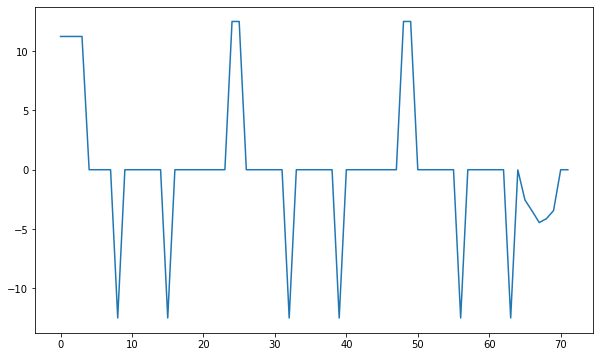

In [98]:
diff_soc = np.diff(soc) * 60 / del_t
plt.plot(diff_soc)